In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_002 import *

In [18]:
DATA_PATH = Path('data')
# PATH = DATA_PATH/'cifar10_dog_air'
PATH = DATA_PATH/'cifar10'

train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test', train_ds.classes)

x = train_ds[1][0]
bs=256
c = len(train_ds.classes)
len(train_ds)

50000

# CIFAR augmentation

## Data

In [95]:
#export
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Start:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Pixel:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()

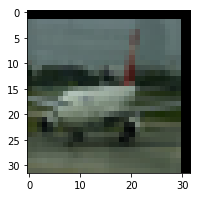

In [96]:
show_image(crop(pad(x, 4, 'constant'), 32, 0.25, 0.75), hide_axis=False)

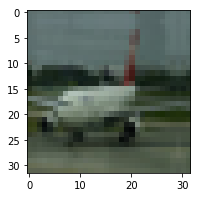

In [97]:
show_image(crop(pad(x, 4), 32, 0.25, 0.75), hide_axis=False)

In [98]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [99]:
#export
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable] = None
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None: x = apply_tfms(self.tfms)(x)
        return x,y
    
class DataBunch():
    def __init__(self, train_ds, valid_ds, bs=64, device=None, train_tfm=None, valid_tfm=None, num_workers=4):
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader.create(TfmDataset(train_ds,train_tfm), bs, shuffle=True, num_workers=num_workers)
        self.valid_dl = DeviceDataLoader.create(TfmDataset(valid_ds, valid_tfm), bs*2, shuffle=False, num_workers=num_workers)
        
    @property
    def train_ds(self): return self.train_dl.dl.dataset
    @property
    def valid_ds(self): return self.valid_dl.dl.dataset

In [100]:
data = DataBunch(train_ds, valid_ds, train_tfm=tfms)

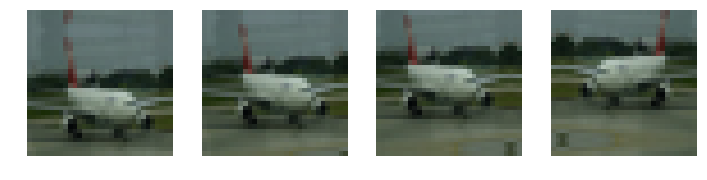

In [101]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(data.train_ds[1][0], ax)

## Normalization and training

In [102]:
# CIFAR 10 stats looked up on google 
data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))

In [103]:
#export
@reg_transform
def normalize(x, mean,std) -> TfmType.Pixel: return (x-mean[...,None,None]) / std[...,None,None]
def denormalize(x, mean,std): return x*std[...,None,None] + mean[...,None,None]

In [104]:
cifar_norm = normalize_tfm(mean=data_mean,std=data_std)

In [105]:
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=12)
len(data.train_dl), len(data.valid_dl)

(196, 20)

In [106]:
x,y = next(iter(data.train_dl))
x = x.cpu()
x.min(),x.max(),x.mean(),x.std()

(tensor(-1.9879), tensor(2.1317), tensor(0.0334), tensor(1.0118))

In [107]:
x = denormalize(x, data_mean, data_std).clamp(0,1.)

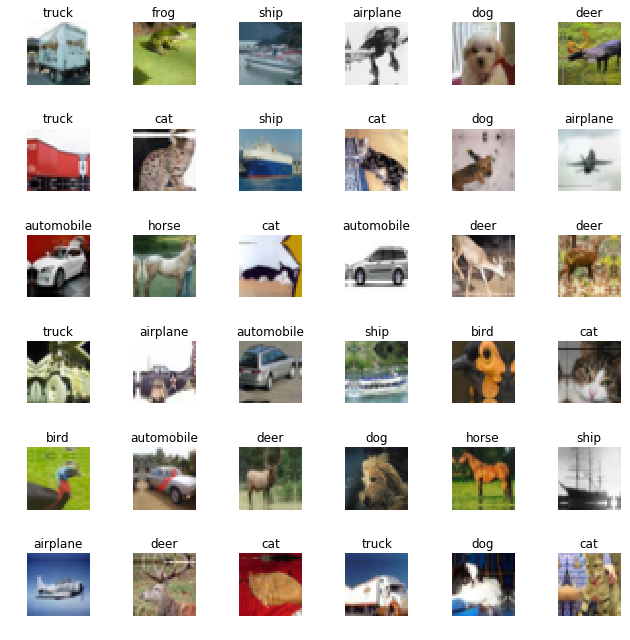

In [108]:
show_images(x,y,6,train_ds.classes)

In [109]:
learn = Learner(data, simple_cnn([3,16,16,c], [3,3,3], [2,2,2]))
opt_fn = partial(optim.SGD, momentum=0.9)

In [52]:
learn.fit(1, 0.2, opt_fn=opt_fn)

0 1.774767830467224


# Darknet

In [110]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [134]:
model = Darknet([1, 2, 4, 6, 3], num_classes=c, nf=16)
# model = Darknet([1, 2, 4, 4, 2], num_classes=c, nf=32)
learner = Learner(data, model)
opt_fn = partial(optim.SGD, momentum=0.9)

In [135]:
for lr in (0.1,0.2,0.4,0.8,0.1,0.01):
    momentum = 0.95 if lr<0.1 else 0.85 if lr>0.5 else 0.9
    learner.fit(2, lr, opt_fn=partial(optim.SGD, momentum=momentum))

0 1.8699882328033448


1 1.6742703117370605



0 1.3796185935974121


1 1.0716916877746583



0 1.7870996158599854


1 0.9515044565200805



0 0.9616677917480468


1 0.7702663630962372



0 0.5503373775482178


1 0.52976398229599



0 0.49822404499053957


1 0.4955230827331543



In [128]:
learner.fit(2, 0.01, opt_fn=opt_fn)

0 0.3919792850971222


1 0.3909005393028259



In [93]:
learner.fit(1, 0.1, opt_fn=opt_fn)

0 1.147604134464264



In [94]:
learner.fit(1, 0.01, opt_fn=opt_fn)

0 0.9177367671966553



# Fin

In [ ]:
# xb.min(),xb.max(),yb.min(),yb.max()